# Assignment 1.2: 

# Theory 
## Questions 
- Why apply a logarithm on the likelihood?  
- What are analytical reasons?  
- What are numerical reasons?  
- Does it affect the estimator?  


## Answers:



By utilising log likelyhood we replace the product of probabilities with a sum of log probabilities.
This means, instead of applying complex chain rules for differentiation, we can just use the sum of the derivatives to compute the derivative
of the sum.
Without applying the logarithm, the probability for training data given a model decreases for every sample with probability smaller then 1 given a model. This leads to potentially very low overall probabilities, which may lead to underflow issues in computation. By applying log and converting into a sum, the value to be maximised doesnt decrease with more samples and only increases gradually, meaning overflow is unlikely.
The estimator is not affected, as the log function is monotonous and therefore it preserves the optimisation objective.

## Task 1
We observe an experiment $D=\{x_1,\cdots, x_n\}$ with i.i.d. $x_i \sim p(x_i|\mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$.
What is the MLE for $\mu$ and $\sigma^2$ ?


Solution:



$\hat{\mu} = \dfrac{1}{n} \sum^{n}_{k=1}x_k$

$\hat{\sigma}^2 = \dfrac{1}{n-1} \sum^{n}_{k=1}(x_k - \hat{\mu})^2$ for one dimension

$\hat{\sigma}^2 = \dfrac{1}{n-1} \sum^{n}_{k=1}(x_k - \hat{\mu})(x_k - \hat{\mu})^T$ for higher dimensions

## Task 2
We observe an experiment $D=\{(x_1,y_1),\cdots, (x_n,y_n)\}$. We assume a linear model with Gaussian noise: $y_i = x_i\cdot a + b + \epsilon_i$  with i.i.d. $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$.
       What is the MLE for $a,b$ and $\sigma^2$ ?
       


### Solution:

With $\bar{x} = \dfrac{1}{n} \sum^{n}_{i=1}x_i$ and $\bar{y} = \dfrac{1}{n} \sum^{n}_{i=1}y_i$

$\hat{a} = \frac{\sum^{n}_{i=1} (x_i - \bar{x})(y_i - \bar{y})}{\sum^{n}_{i=1} (x_i - \bar{x})^2} $

$\hat{b} = \bar{y} - \hat{a} \bar{x}$

$\hat{\sigma}^2 = \dfrac{1}{n-2} \sum^{n}_{i=1}(y_i - x_i \cdot \hat{a} + \hat{b})^2$  $\hspace{3cm}$ #-2 since we have non zero intercept

## Task 3
Assume we have a Bernoulli process, where we toss a coin multiple times.  
Let $D = (x_1, x_2, . . . , x_7) = (0, 0, 1, 1, 0, 0, 1)$ be the measurements. 
Assume $p(x_i|\theta)=
\begin{cases}
\theta  & \text{if} ~ x_i=1 ~ (head),\\
1-\theta ~ &\text{if} ~ x_i=0 ~ (tail)
\end{cases}$

- Let $p(\theta)=\mathcal{N}(0.5,0.1)$. What is the MAP estimator $\theta_{MAP}$? What is the probability of tossing tails two times $P(x_8=0, x_9=0|\theta_{MAP})$
- Let $p(\theta)=\mathcal{U}(0,1)$. What is the probability of the next toss to be head $P(x_8=1|D)$ 


### Solution:



With $p(D |θ) = θ^k ·(1 −θ)^{n−k}$

$θ_{MAP} = \underset{θ}{argmax}$ $θ^k ·(1 −θ)^{n−k} \cdot \mathcal{N}(0.5,0.1)$

Using the log likelyhood and set the derivative to zero

$\frac{3}{θ} - \frac{4}{1-θ} - \frac{θ-0.5}{0.1} = 0$

Leads to a MAP estimate of 0.44 for θ. Therefore the probability for two tails in a row given $θ_{Map}$ is $(1 - 0.44)^2 = 0.31$


When using a uniform distribution as a prior, means as all values of θ are equally likely, meaning in this case:

$p(θ | D) = p(D | θ)p(θ) = p(D | θ)

With $\hat{θ}_{MLE} = \frac{3}{7} = 0.43$, meaning $P(x_8=1|D) = 0.43$

# Praxis

The goal of the exercise is to implement a Maximum Likelihood Estimator for a normal distribution.  
We create $n$ data samples from a 2D normal distribution $X_i \sim \mathcal{N}(\mu, \Sigma)$

We would like to estimate the mean $mu$ using a numerical appraoch with gradient ascent.

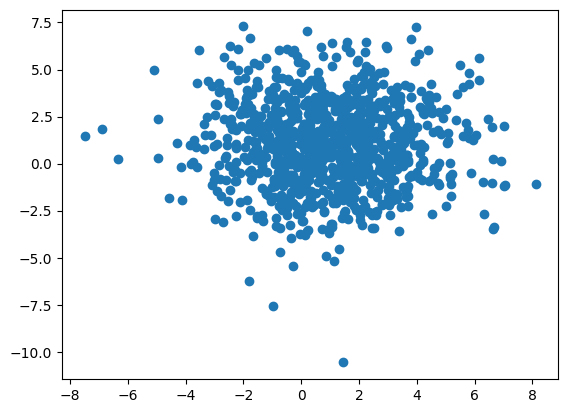

In [194]:
import numpy as np 
import torch
import matplotlib.pyplot as plt

n = 1000 # number of samples (descrease the number if computations take too much time)
mu, sigma = np.ones(2), 5*np.eye(2) # mean and standard deviation of ground truth distribution
data = np.random.multivariate_normal(mu, sigma, n) # sample n data points from the distribution
plt.scatter(data[:,0],data[:,1])
plt.show()


# Maximum Likelihood

The likelihood of a single data point is given as:  
$$p(x; \mu, \Sigma) = \dfrac{1}{\sqrt{|\Sigma|(2\pi)^2}} 
  \exp\left( -\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T \right)$$

The log-likelihood is:
$$\log (p(x; \mu, \Sigma)) =-\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T  + C $$

The joint likelihood over the whole data is:  
$$p(D;\mu, \Sigma) = \prod_i^n p(x_i; \mu, \Sigma)$$

We would like to find $\mu$ that has the highest likelihood for the given data. We assume for now, that $\Sigma$ is known:
$$ \max_\mu  p(D;\mu, \Sigma) $$
This is equivalent to maximizing the log-likelihood:
$$\Leftrightarrow  \max_\mu L(\mu) := \log (p(D;\mu, \Sigma))$$ 

Since $L(\mu)$ is a differentiable function, we can try to find the maximum using gradient ascent to find the local maximum.  
We can utilize Pytorch automatic differentiation to compute the gradients for us.  

Given are two heper functions:
1. the log-likelihood $L(\mu)$ for a given dataset
2. a visualization of the log-likelihood over a range $[-5,5]\times [-5,5]$ as a heatmap.

In [7]:
def L(X, mu, sigma):
    """ 
    Computes the log-likelihood over a dataset X for an estimated normal distribution parametrized 
    by mean mu and covariance sigma

    X : Tensor 
        A data matrix of size n x 2 
    mu: Tensor of size 2
        a tensor with two entries describing the mean
    sigma: Tensor of size 2x2
        covariance matrix
    """
    diff = X-mu
    z = -0.5*diff@sigma.inverse()*diff
    return z.sum()

def vizualize(X, mus, sigma):
    """ 
    Plots a heatmap of a likelihood evaluated for different mu.
    It also plots a list of gradient updates. 

    X : Tensor 
        A data matrix of size n x 2 
    mus: list[Tensor]  
        A list of 2D tensors. The tensors should be detached from and on CPU.
    sigma: Tensor of size 2x2
        covariance matrix
    """
    loss = lambda x,y: L(X,torch.tensor([x,y]),sigma)
    loss = np.vectorize(loss)
    space = np.linspace(-5,5,100)
    x,y  = np.meshgrid(space,space)
    zs = np.array(loss(np.ravel(x), np.ravel(y)))
    z = zs.reshape(x.shape)
    plt.pcolormesh(x,y, z )

    mu_x, mu_y = zip(*mus)
    plt.plot(mu_x, mu_y)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.show()


### Example Use of functions:

/tmp/ipykernel_840/317599243.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


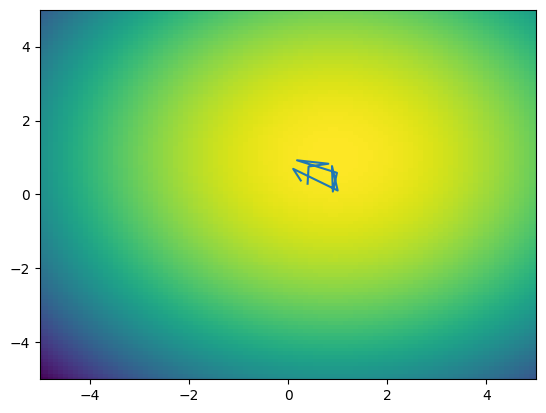

In [22]:
mu = torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

loss = L(X,mu, sigma)  # computing loss
loss.backward()  # backpropagation
mu.grad  # gradients are stored in the object

mus = [torch.rand(2) for _ in range(10)] # a list 2D mu updates (dont)
vizualize(X,mus,sigma) 

## Task 1 : MLE using gradient ascent

Find the maximum by computing gradient ascent:
$$ \mu_{t+1} = \mu_{t} + \lambda \dfrac{d}{d \mu}L(\mu) $$

1. Implement a function that does the following steps:
    - initialize $\mu_0 = (0,0)^T$
    - compute Likelihood $L(\mu)$ 
    - calculate gradient $\dfrac{d}{d \mu} L(\mu)$ using Pytorch's automatic differentiation
    - update $\mu$
    - repeat until convergence or after certain amount of steps 
2. Visualize your gradient updates
3. How does the learning rate $\lambda$ affect convergence?

/tmp/ipykernel_840/1103974537.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


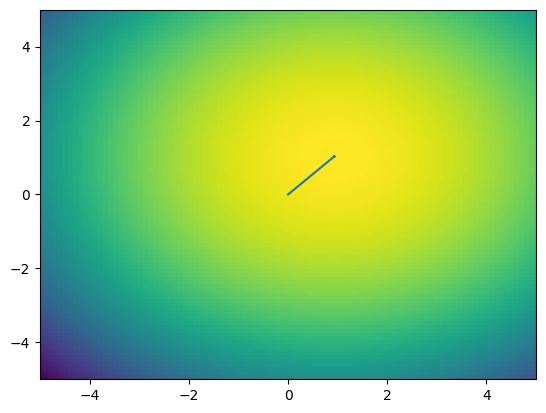

In [192]:
mu = torch.nn.Parameter(torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True)) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor
stepsize = 0.002

mus = [mu.detach().clone()]

for i in range(100):
        loss = L(X,mu, sigma)  # computing loss
        mu.requires_grad=True
        mu.grad = None
        loss.backward()  # backpropagation
        with torch.no_grad():
                mu += mu.grad * stepsize
        mus.append(mu.detach().clone().numpy())


vizualize(X,mus,sigma) 

### Task 1. Question 3: How does the learning rate $\lambda$ affect convergence?



Smaller learning rate leads to slower convergence but smaller difference between values converged to, meaning more accuracy and vice verca for large values. The result therefor is highly dependent on a good learning rate to converge in reasonable time to a good value.

## Task 2: Better Gradient Updates

1. Change your vanilla gradient updates to a more sophisticated approach.  You can use any of Pytorch's optimization methods:  https://pytorch.org/docs/stable/optim.html
2. Visualize the new gradient updates
3. How and why do these methods differ?

/tmp/ipykernel_840/1664487515.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


[tensor([0., 0.], dtype=torch.float64), array([0.5, 0.5]), array([0.96035615, 0.96806096]), array([1.30684887, 1.34600548]), array([1.47317692, 1.56750613]), array([1.47763237, 1.62629821]), array([1.37418618, 1.56422421]), array([1.20860539, 1.42521806]), array([1.01733095, 1.24461432]), array([0.83309262, 1.05275401]), array([0.68551068, 0.87783718]), array([0.59571722, 0.74431706]), array([0.57100988, 0.66797506]), array([0.60579151, 0.65274841]), array([0.68659742, 0.69238107]), array([0.79622925, 0.77439789]), array([0.91589116, 0.88321126]), array([1.02675979, 1.00184509]), array([1.11229601, 1.11328794]), array([1.16113723, 1.20237663]), array([1.1690565 , 1.25813449]), array([1.13889381, 1.27552887]), array([1.0789815 , 1.25574072]), array([1.00120288, 1.20511057]), array([0.91916721, 1.13357003]), array([0.84632294, 1.05308052]), array([0.7938688 , 0.97607806]), array([0.76884545, 0.91378017]), array([0.77309154, 0.87448654]), array([0.8033805 , 0.86232997]), array([0.85245801

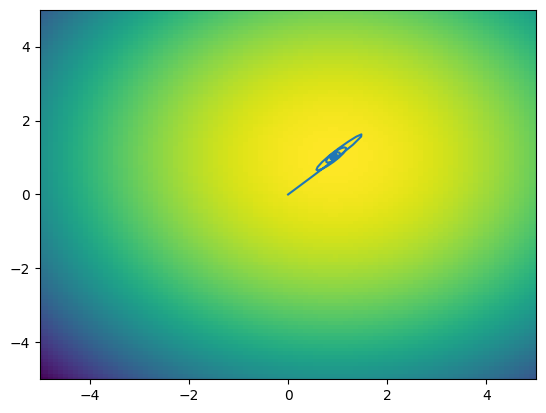

In [174]:
mu = torch.nn.Parameter(torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True)) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

optimizer = torch.optim.Adam([mu], lr=0.5)

mus = [mu.detach().clone()]

for i in range(100):
        loss = L(X,mu, sigma)  # computing loss
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # backpropagation
        mu.grad *= -1   # gradient ascent
        optimizer.step()
        mus.append(mu.detach().clone().numpy())
print(mus)
vizualize(X,mus,sigma) 

### Task 2. Question 3: How and why do these methods differ?



The optimiser uses a more adaptive approach for the applied learning rate which also incorporates momentum. Its is thereby much more forgiving in respect to the initial choice of learning rate.

## Task 3: Stochastic Gradients

Instead of optimizing over all data points
$$\max_\mu L(\mu) = \log (p(D;\mu, \Sigma))$$ 

take smaller random subsets $\hat{D} \subset D$ and optimize over approximation:
    $$\max_\mu \hat{D}(\mu) = \log (p(\hat{D};\mu, \Sigma))$$ 

1. Change your optimization method by taking random subsets of $\hat{D} \subset D$ in each iteration. 
    - How does the size $k:=|\hat{D}|$ affect convergence?
2. Visualize the log-likelihood over the whole data and for smaller subsets $k \in \{1, 5, 10, 100, 1000, ...\}$
    - What conclusions can you make?

#### 1

/tmp/ipykernel_840/810227839.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


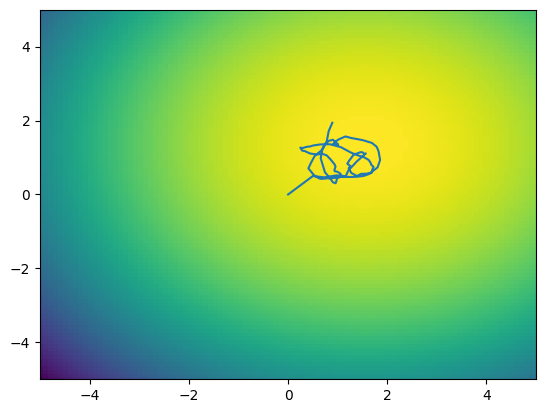

In [233]:
mu = torch.nn.Parameter(torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True)) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix

import random
k = 5

optimizer = torch.optim.Adam([mu], lr=0.5)

mus = [mu.detach().clone()]

for i in range(100):
        mini_batch = random.sample(list(data), k)
        X = torch.tensor(mini_batch,dtype=torch.float64)  # data samples as tensor

        loss = L(X,mu, sigma)  # computing loss
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # backpropagation
        mu.grad *= -1   # gradient ascent
        optimizer.step()
        mus.append(mu.detach().clone().numpy())
vizualize(X,mus,sigma) 

The smaller the mini-batch, the more noisy the learning result

#### 2

/tmp/ipykernel_840/1750330887.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix


1


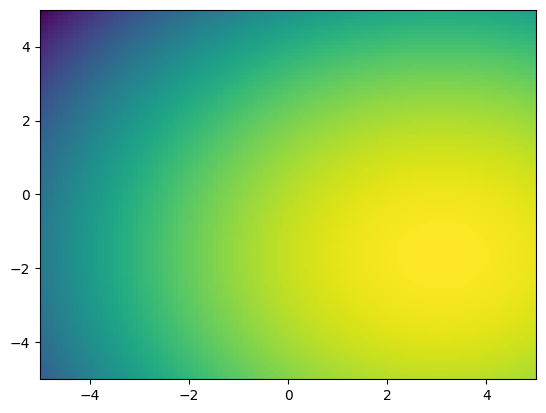

5


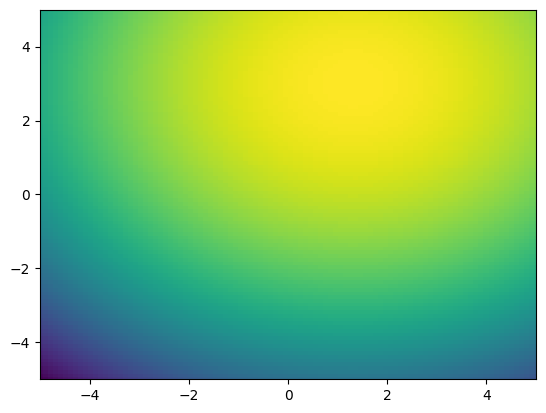

10


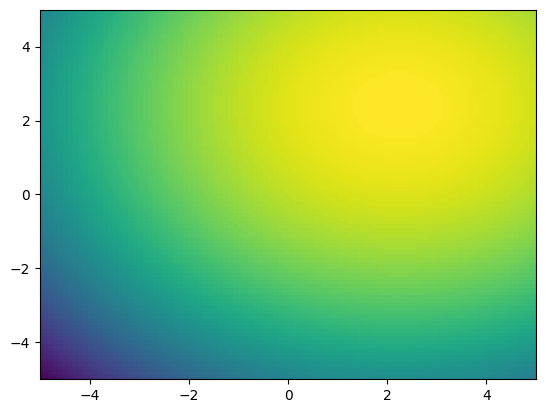

100


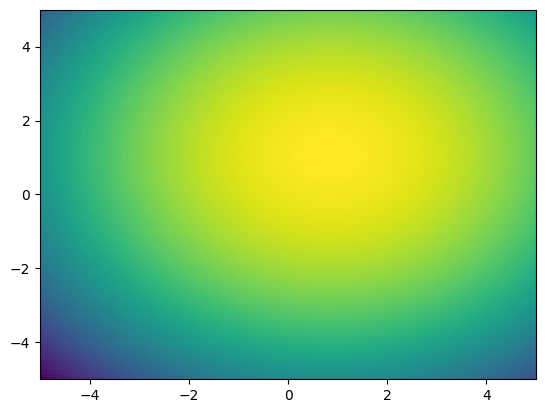

1000


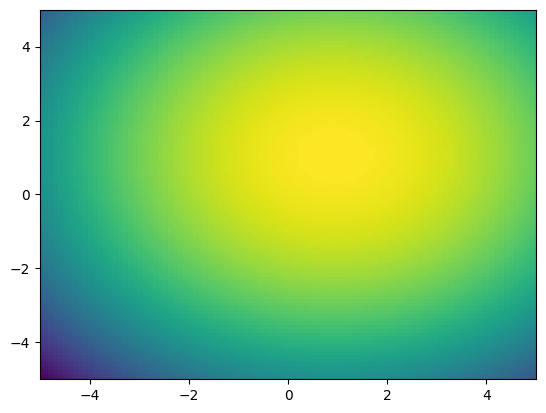

In [240]:
mu = torch.nn.Parameter(torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True)) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix

import random
k = [1, 5, 10, 100, 1000, 2000, 5000]

for i in k:
    if i > len(data):
        break
    print(i)
    mini_batch = random.sample(list(data), i)
    X = torch.tensor(mini_batch,dtype=torch.float64)  # data samples as tensor
    vizualize(X, [mu.detach().clone()], sigma)

The smaller the mini-batch, the higher the likelihood it does not appropriately describe the overall data destribution. 

### Task 3. Question 1: How does the size $k:=|\hat{D}|$ affect convergence?




### Task 3. Question 2: What conclusions can you make?

The bigger the mini-batch, meaning the larger the k, the faster and more preceise the convergence. Full batch learning with $k=|D|$ is most optimal for a precise converging model, though applying methods to a full batch might be too computationally complex in some cases.